In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
import datetime

import tensorflow as tf
from tensorflow.keras import layers,models,utils
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard,Callback

import matplotlib.pyplot as plt

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [3]:
class SkipLoggerCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, n):
        self.n = n
        
    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.n == 0:
            loss = logs.get('loss')
            accuracy = logs.get('accuracy')
            val_loss = logs.get('val_loss')
            val_accuracy = logs.get('val_accuracy')
            print("epoch = %4d    loss = %0.6f    accuracy = %0.2f    val_loss = %0.6f    val_accuracy = %0.2f" % (epoch, loss, accuracy, val_loss, val_accuracy))

In [4]:
DATA_DIR = 'data/caps_and_shoes_squared/'
IMAGE_SIZE = (28,28)
CLASS_LIST = ['cap','shoes']
BATCH_SIZE = 32

train_path = DATA_DIR + 'train'
validation_path = DATA_DIR + 'val'
test_path = DATA_DIR + 'test'

In [5]:
test_img_generator = ImageDataGenerator( rescale = 1./255)
img_generator = ImageDataGenerator(rescale = 1./255, rotation_range = 10, width_shift_range = 0.1, height_shift_range=0.1, zoom_range = 0.1, 
                                   horizontal_flip=True, fill_mode='nearest')
train_validation_img_generator = ImageDataGenerator(validation_split=0.2, rescale = 1./255, rotation_range = 10, width_shift_range = 0.1, height_shift_range=0.1, zoom_range = 0.1, 
                                   horizontal_flip=True, fill_mode='nearest')

train_partial_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical', batch_size=BATCH_SIZE, subset='training')

train_validation_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical', batch_size=BATCH_SIZE, subset='validation')

train_full_batches = img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical', batch_size=BATCH_SIZE)

validation_batches = img_generator.flow_from_directory(validation_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical', batch_size=BATCH_SIZE)
test_batches = test_img_generator.flow_from_directory(test_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical',batch_size=1, shuffle=False)

Found 1832 images belonging to 2 classes.
Found 457 images belonging to 2 classes.
Found 2289 images belonging to 2 classes.
Found 670 images belonging to 2 classes.
Found 326 images belonging to 2 classes.


In [6]:
def define_model_architecture_64_32_16():
    model = models.Sequential()
    model.add(Flatten(input_shape = (28,28,1)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [7]:
skipLogger_callback = SkipLoggerCallback(n=10)

In [8]:
!rm -rf ./logs/
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [9]:
model = define_model_architecture_64_32_16()
history = model.fit_generator(generator = train_partial_batches, steps_per_epoch=train_partial_batches.samples/BATCH_SIZE, 
                              validation_data = train_validation_batches, validation_steps = train_validation_batches.samples/BATCH_SIZE, 
                              epochs=500, verbose=0, workers=4, callbacks = [skipLogger_callback,tb_callback])

W0817 23:05:13.936380 140342705432384 deprecation.py:323] From /home/algolaptop8/anaconda3/envs/tf2-env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


epoch =    0    loss = 0.690957    accuracy = 0.55    val_loss = 0.710639    val_accuracy = 0.56
epoch =   10    loss = 0.590348    accuracy = 0.68    val_loss = 0.607789    val_accuracy = 0.70
epoch =   20    loss = 0.554581    accuracy = 0.72    val_loss = 0.645084    val_accuracy = 0.66
epoch =   30    loss = 0.536371    accuracy = 0.74    val_loss = 0.570028    val_accuracy = 0.75
epoch =   40    loss = 0.536010    accuracy = 0.74    val_loss = 0.521221    val_accuracy = 0.76
epoch =   50    loss = 0.498566    accuracy = 0.76    val_loss = 0.624390    val_accuracy = 0.67
epoch =   60    loss = 0.490840    accuracy = 0.76    val_loss = 0.528526    val_accuracy = 0.74
epoch =   70    loss = 0.477828    accuracy = 0.78    val_loss = 0.483179    val_accuracy = 0.79
epoch =   80    loss = 0.482165    accuracy = 0.76    val_loss = 0.498180    val_accuracy = 0.79
epoch =   90    loss = 0.459221    accuracy = 0.78    val_loss = 0.497385    val_accuracy = 0.78
epoch =  100    loss = 0.45254

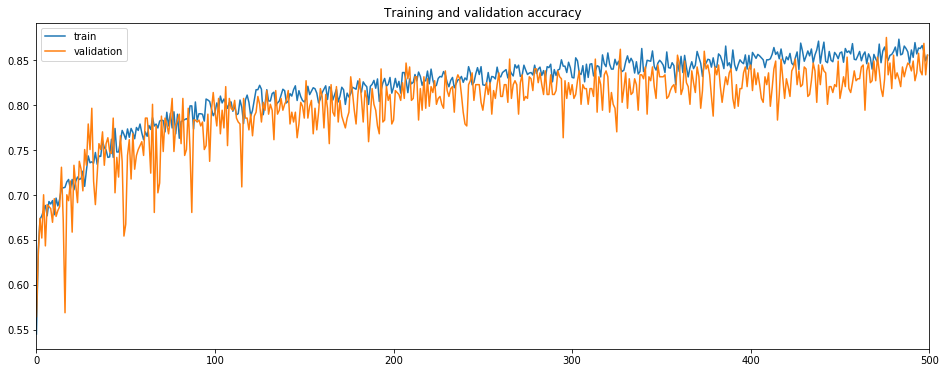

In [10]:
plt.figure(num=None, figsize=(16, 6))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.title('Training and validation accuracy')
plt.xlim(0, 500)
plt.show()

In [11]:
model.save("model/model_cross_valid_500.h5")

In [12]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [13]:
model = define_model_architecture_64_32_16()
history = model.fit_generator(generator = train_full_batches, steps_per_epoch=train_full_batches.samples/BATCH_SIZE, 
                              validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE, 
                              epochs=300, verbose=0, workers=4, callbacks = [skipLogger_callback,tb_callback])

epoch =    0    loss = 0.683570    accuracy = 0.59    val_loss = 0.640927    val_accuracy = 0.66
epoch =   10    loss = 0.572130    accuracy = 0.71    val_loss = 0.545310    val_accuracy = 0.72
epoch =   20    loss = 0.546627    accuracy = 0.73    val_loss = 0.512286    val_accuracy = 0.74
epoch =   30    loss = 0.516871    accuracy = 0.75    val_loss = 0.484831    val_accuracy = 0.76
epoch =   40    loss = 0.498604    accuracy = 0.76    val_loss = 0.475343    val_accuracy = 0.77
epoch =   50    loss = 0.487148    accuracy = 0.77    val_loss = 0.433658    val_accuracy = 0.81
epoch =   60    loss = 0.466180    accuracy = 0.77    val_loss = 0.410885    val_accuracy = 0.83
epoch =   70    loss = 0.455072    accuracy = 0.79    val_loss = 0.449056    val_accuracy = 0.79
epoch =   80    loss = 0.443262    accuracy = 0.79    val_loss = 0.444742    val_accuracy = 0.79
epoch =   90    loss = 0.430244    accuracy = 0.80    val_loss = 0.416870    val_accuracy = 0.79
epoch =  100    loss = 0.42208

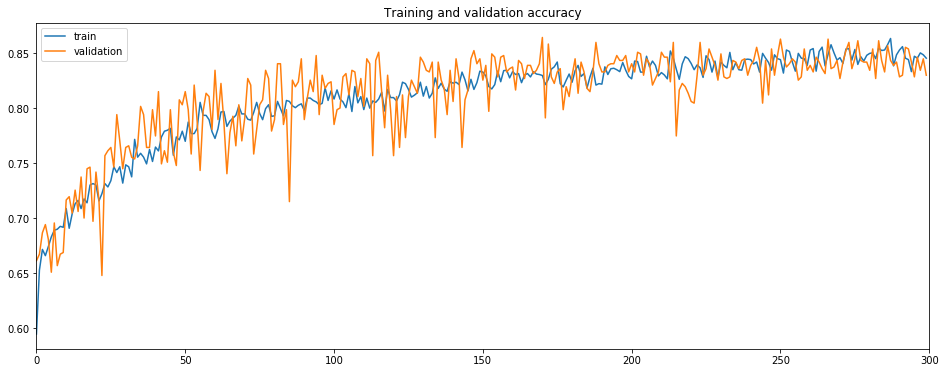

In [14]:
plt.figure(num=None, figsize=(16, 6))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.title('Training and validation accuracy')
plt.xlim(0, 300)
plt.show()

In [15]:
model.save("model/model_lo_valid_300.h5")